In [28]:
import json
import numpy as np
import pandas as pd
from faker import Faker

In [29]:
# read in the data
secrecy_df = pd.concat(
    [
        pd.read_csv("/workspace/data/source/normalized_train.csv"),
        pd.read_csv("/workspace/data/source/normalized_test.csv"),
    ]
).sample(frac=1).reset_index(drop=True)


In [30]:
secrecy_df.head()

,label,text,featureText
0,0,"Similarly, you can use the FTR tool to find ou...",similarly you can use the ftr tool to find out...
1,0,Individual agencies that have elected to parti...,individual agencies that have elected to parti...
2,0,Laurel and Clara are reviewing this one - it m...,laurel and clara are reviewing this one it mon...
3,0,Janette Elbertson is going to handle the migra...,janette elbertson is going to handle the migra...
4,0,"""The magazine's got a long list of contributo...",the magazines got a long list of contributors...


In [6]:
from collections import Counter
Counter(secrecy_df["label"].tolist())

Counter({0: 1007889, 1: 1196})

In [31]:
THRESHOLD = 0.7
evaluation_information = [
    {
        "evaluation_id": "Q1-evaluation",
        "positive_probability": 0.30,
        "total_communications": 56785,
        "date": "2023-04-01"
    },
    {
        "evaluation_id": "Q2-evaluation", 
        "positive_probability": 0.28,
        "total_communications": 64237,
        "date": "2023-07-01"
    }, 
    {
        "evaluation_id": "Q3-evaluation",
        "positive_probability": 0.32,
        "total_communications": 58763,
        "date": "2023-10-01"
    }, 
    {
        "evaluation_id": "Q4-evaluation", 
        "positive_probability": 0.05,
        "total_communications": 72043,
        "date": "2024-01-01"
    }
]
comm_types = ["alert", "no alert"]

positive_index = secrecy_df[secrecy_df["label"] != 0].index
negative_index = secrecy_df[secrecy_df["label"] == 0].index

In [32]:
%time

# generate a beta distro with alpha=0.1 and beta=5 for negative confidence scores
# generate a beta distro with alpha=5 and beta=0.1 for positive confidence scores
# filter to ensure they don't violate the threshold logic
import numpy as np
negative_scores = [x for x in np.random.beta(0.15, 5, 100000) if x < THRESHOLD]
positive_scores = [x for x in np.random.beta(5, 0.1, 100000) if x >= THRESHOLD]
import random
fake = Faker()
# generate the evaluation results
evaluation_results = {}
for evaluation in evaluation_information:
    # instantiate the quarter container
    quarter = {
        "meta": {
            "workflow": evaluation["evaluation_id"],
            "communications": evaluation["total_communications"],
            "date": evaluation["date"]
        },
        "classifiers": [
            {
                "id": 1,
                "name": "MODEL:smarsh-secrecy-en:secrecy-en-lr:1.2.0",
                "threshold": THRESHOLD,
                "labels": ["secrecy","no"]
            }
        ],
        "communications": []
    }
    # generate the evaluation results
    
    for i in range(0, evaluation["total_communications"]):
        # print(f'comm_id: {i}')
        comm_type = np.random.choice(comm_types, p=[evaluation["positive_probability"], 1 - evaluation["positive_probability"]])
        # print(f'comm_type: {comm_type}')
        sentence_count = np.random.randint(1, 4)
        # print(f'sentence_count: {sentence_count}')
        if comm_type == "alert":
            sample_index = random.choices(positive_index, k=1) + random.choices(negative_index, k=sentence_count - 1)
            index_with_probs = [
                {"index": index, "prob": random.choice(positive_scores)} 
                if idx == 0 else {"index": index, "prob": random.choice(negative_scores)}
                for idx, index in enumerate(sample_index)
            ]
        else:
            sample_index = random.choices(negative_index, k=sentence_count)
            index_with_probs = [{"index": index, "prob": random.choice(negative_scores)} for idx, index in enumerate(sample_index)]
        features = []
        for j, idx in enumerate(index_with_probs):
            if "Q4" in evaluation["evaluation_id"]:
                sentence = secrecy_df.loc[idx["index"], "featureText"] + fake.text(max_nb_chars=30).lower()
            else:
                sentence = secrecy_df.loc[idx["index"], "featureText"]
            features.append(
                {
                    "recordIdentifier": f'{i}.{j}',
                    "sentence": sentence,
                    "classifiers": [
                        {
                            "id": "1",
                            "confidence": [1-idx["prob"], idx["prob"]]
                        }
                    ]
                }
            )
        quarter["communications"].append({"messageId": i, "features": features})
            
    evaluation_results[evaluation["evaluation_id"]] = quarter  


CPU times: user 2 μs, sys: 2 μs, total: 4 μs
Wall time: 12.4 μs


In [9]:
evaluation_results.get("Q4-evaluation")["communications"][:5]

[{'messageId': 0,
  'features': [{'recordIdentifier': '0.0',
    'sentence': 'marcusevans conference being held fulldatetoken and numtoken numtoken in new york cityHave either foot.',
    'classifiers': [{'id': '1',
      'confidence': [0.7624000043560349, 0.23759999564396508]}]},
   {'recordIdentifier': '0.1',
    'sentence': 'for more information about atm please visit our website at urltoken or call cynthia ashton at phonenumbertoken Who budget nation million.',
    'classifiers': [{'id': '1',
      'confidence': [0.5983980772197308, 0.40160192278026924]}]},
   {'recordIdentifier': '0.2',
    'sentence': 'we have the conversation toilet i think so i think we month decide by the block to be on it and i think that we need to we need to time those we want to obviously protest Threat must next.',
    'classifiers': [{'id': '1',
      'confidence': [0.7582191494395094, 0.24178085056049053]}]},
   {'recordIdentifier': '0.3',
    'sentence': ' democrats and environmentalists in response ar

In [33]:
with open("/workspace/data/evaluation_results_nested.json", "w") as f:
    json.dump(evaluation_results, f)

In [32]:
random.choice(s)

0.006305485647262274

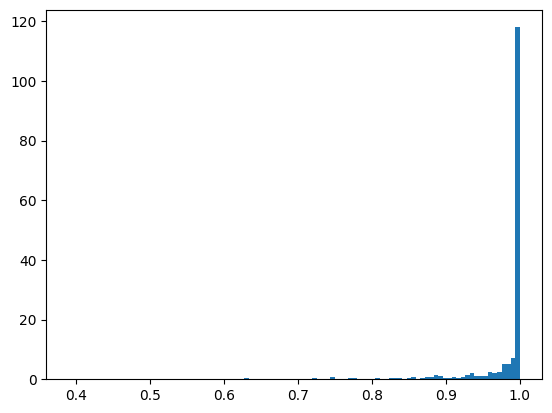

In [2]:
import numpy as np
s = np.random.beta(5, 0.1, 1000)
import matplotlib.pyplot as plt
plt.hist(s, 100, density=True)
plt.show()

In [55]:
evaluation_results.get("Q1-evaluation").get("results")[:10]

[{'recordIdentifier': '0.0',
  'sentence': 'dont tell shank i told you ',
  'classifiers': [{'id': '1',
    'confidence': [0.23218912825740212, 0.7678108717425979]}]},
 {'recordIdentifier': '0.1',
  'sentence': 'the term data are the way the deal was entered with deal entry deal blotter or eol bridge signed and confirmed ',
  'classifiers': [{'id': '1',
    'confidence': [0.6384768107900185, 0.3615231892099815]}]},
 {'recordIdentifier': '0.2',
  'sentence': 'it can be as long as you keep these pointers in mind ',
  'classifiers': [{'id': '1',
    'confidence': [0.3545821594052815, 0.6454178405947185]}]},
 {'recordIdentifier': '1.0',
  'sentence': 'hotelu okolo godziny numtoken czasu lokalnego czyli godziny numtoken numtoken wieczorem czasu',
  'classifiers': [{'id': '1',
    'confidence': [0.5804730085964007, 0.4195269914035993]}]},
 {'recordIdentifier': '1.1',
  'sentence': 'ten three nametoken',
  'classifiers': [{'id': '1',
    'confidence': [0.559584532328686, 0.440415467671314]}]}

In [5]:
import plotly.express as px

df = px.data.gapminder().query("continent=='Oceania'")

df.shape[0]

24

In [8]:
# get page html with bs4

from bs4 import BeautifulSoup as bs
import requests

url = "https://www.shieldfc.com/resources/blog/the-byom-advantage-maximizing-ai-investments-in-financial-compliance/"
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

response = requests.get(url, headers=headers)

soup = bs(response.content, "html.parser")

In [27]:
[print(x) for x in (soup(text=lambda t: "Lucena" in t.text))]

[]